# Recurrent Neural Network - Predict Stock Market with Finance Data and News Data
The source of inspiration was this blog post: 
https://medium.com/@dmytrosazonov/how-to-predict-stock-market-using-google-tensorflow-and-lstm-neural-network-81ccc41a22a8

This is the basis for training the neural network. 

# Import necesary libraries

In [60]:
import os

import numpy as np
from numpy import array
from numpy import hstack

from math import sqrt

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from pandas import DataFrame
from pandas import concat

# AI
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.metrics import RootMeanSquaredError
import datetime

# Graphics library
import matplotlib.pyplot as plt

# Set random seed for reproducibility
from numpy.random import seed
seed(42)
rng = np.random.RandomState(42)

import warnings

import tensorflow
tensorflow.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Settings

In [2]:
# Set the parametes need for the RNN

# Stock ticker, TSLA. Here we will get the stick ticker the others too.
STOCK = 'TSLA'

# Load Data

In [3]:
import duckdb
import os

class PredictionInputRepository:
    def __init__(self, csv_file_path=None):
        self.connection = duckdb.connect(database=':memory:', read_only=False)
        if os.path.isfile(f'{csv_file_path}/prediction_input.csv'):
            try:
                self.connection.execute(f"IMPORT DATABASE '{csv_file_path}';")
            except Exception as e:
                self._create_table()
                self.connection.execute(f"EXPORT DATABASE '{csv_file_path}';")
        else:
            self._create_table()

    def _create_table(self):
        self.connection.execute("CREATE TABLE prediction_input (id VARCHAR UNIQUE, articleId INTEGER UNIQUE, timestamp VARCHAR, close DOUBLE, relevance DOUBLE, sentimentPositive DOUBLE, sentimentNegative DOUBLE, sentimentNeutral DOUBLE)")
        self.connection.execute("CREATE SEQUENCE id_sequence START 1 INCREMENT BY 1;")

    def insert(self, prediction_input):
        self.connection.execute("PREPARE insert_prediction_input AS "
                                "INSERT INTO prediction_input VALUES (nextval('id_sequence'), ?, ?, ?, ?, ?, ?, ?) ON CONFLICT DO NOTHING;")
        self.connection.execute(f"EXECUTE insert_prediction_input('{prediction_input['articleId']}', '{prediction_input['timestamp']}', {prediction_input['close']}, {prediction_input['relevance']}, {prediction_input['sentimentPositive']}, {prediction_input['sentimentNegative']}, {prediction_input['sentimentNeutral']});")

    def select_all(self):
        return self.connection.execute("SELECT * FROM prediction_input").fetchdf()

    def select_by_date(self, date_from, date_to):
        return self.connection.execute(f"SELECT * FROM prediction_input WHERE strptime(timestamp, '%Y-%m-%dT%H:%M:%S%z') BETWEEN strptime('{date_from}','%Y-%m-%d') AND strptime('{date_to}','%Y-%m-%d')").fetchdf()
    
    def select_by_date_order(self, date_format = '%Y-%m-%dT%H:%M:%S%z'):
        return self.connection.execute(f"SELECT * FROM prediction_input ORDER BY strptime(timestamp, '{date_format}') DESC").fetchdf()

    def export(self, csv_file):
        self.connection.execute(f"EXPORT DATABASE '{csv_file}';")


# Prepare Prediction Input

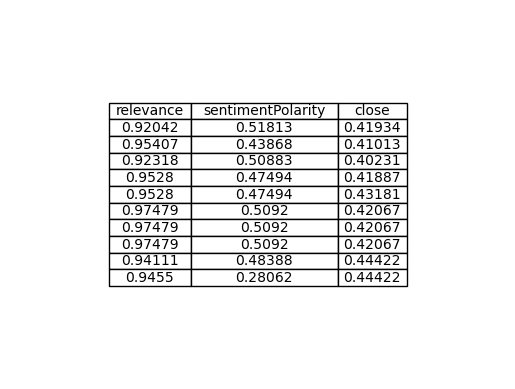

In [4]:
def prepare_prediction_input(source):
    prediction_input_repo = PredictionInputRepository(f"prediction_input/{source}")

    if source == "bbc":
        return prediction_input_repo.select_by_date_order("%Y-%m-%dT%H:%M:%S.%fZ")
    else:
        return prediction_input_repo.select_by_date_order()

# input as df
def show_prediction_input_table(prediction_input):
    most_ten_input_data = prediction_input.tail(10)
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    table = plt.table(cellText=most_ten_input_data.values, colLabels=most_ten_input_data.columns, cellLoc = 'center', loc='center')
    table.auto_set_column_width(col=list(range(len(most_ten_input_data.columns))))
    plt.show()
    
def plot_graph(input_df, column_name):
    plt.figure(figsize=(16,10))
    plt.plot(input_df[column_name])
    plt.xlabel("days")
    plt.ylabel("price")
    plt.legend([f'{column_name} for {STOCK}'])
    plt.show()

def calculate_sentiment_polarity(rows):
    rows["sentimentPolarity"] = round(rows['sentimentPositive'] - rows['sentimentNegative'],5)
    rows["sentimentPolarity"] = np.interp(rows["sentimentPolarity"], (-1, 1), (0, 1)) if rows["relevance"] > 0 else 0
    rows = rows.drop(['sentimentPositive', 'sentimentNegative', 'sentimentNeutral'])
    return rows

def calculate_statistics_per_day(input, statistics = True):
    input["timestamp"] = input["timestamp"].apply(lambda x: x.split("T")[0])
    input_temp = input.drop(input[input.relevance <= 0].index)
    
    stats = ["mean", "median", "std"] if statistics else ["mean"]
    
    input_temp = (input_temp.groupby(["timestamp"], as_index=False)).agg({"relevance": stats, "sentimentPolarity": stats})
    
    if statistics:
        input_temp.columns = [("_".join(x) if x[1] != "" else x[0]) for x in input_temp.columns.ravel()] 
    else:
        input_temp.columns = [x[0] for x in input_temp.columns.ravel()]

    return input_temp

def forward_fill_missing_dates_values(input_df):
    input_df["timestamp"] = pd.to_datetime(input_df["timestamp"])
    input_df = input_df.set_index("timestamp")
    input_df = input_df.resample("D").ffill().reset_index()
    return input_df

def add_close_price_per_date(input_df):    
    min_date = str(input_df["timestamp"].min()).split(" ")[0]
    max_date = str(input_df["timestamp"].max()).split(" ")[0]
    
    stock_df = yf.get_data(
        STOCK,
        start_date=min_date,
        end_date=max_date,
        interval='1d')
    stock_df = stock_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
    stock_df['date'] = stock_df.index
    
    input_df = pd.merge(input_df, stock_df, left_on="timestamp", right_on="date", how="left").drop("date", axis=1)
    
    return input_df

def fill_missing_close_price_values(input_df):
    input_df["close"] = input_df["close"].ffill().bfill()
    return input_df

def fill_missing_statistics(input_df, statistics = True):
    if statistics:
        input_df["relevance_std"] = input_df["relevance_std"].fillna(0)
        input_df["sentimentPolarity_std"] = input_df["sentimentPolarity_std"].fillna(0)
    else:
        input_df["relevance"] = input_df["relevance"].fillna(0)
        input_df["sentimentPolarity"] = input_df["sentimentPolarity"].fillna(0)
    return input_df

def round_values(input_df):
    input_df = input_df.round(5)
    return input_df

def transform_close_price_min_max(input_df):
    input_df["close"] = input_df["close"].apply(lambda x: np.interp(x, (input_df["close"].min(), input_df["close"].max()), (0, 1)))
    return input_df

def shift_closing_price(input_df, shift):
    input_df["close"] = input_df["close"].shift(-shift)
    return input_df

def get_future(input_df, future_days = 1):
    input_df["future"] = input_df["close"].shift(future_days)
    return input_df

def get_processed_dataframe_prediction_input(source, exclude_col=None, statistics = True):
    if exclude_col is None:
        exclude_col = []
    
    input_df = prepare_prediction_input(source).drop("close", axis=1)
    input_df = input_df.apply(calculate_sentiment_polarity, axis=1)
    
    input_df = calculate_statistics_per_day(input_df, statistics)
    input_df = forward_fill_missing_dates_values(input_df)
    input_df = add_close_price_per_date(input_df)

    min_close = input_df["close"].min()
    max_close = input_df["close"].max()

    input_df = fill_missing_close_price_values(input_df)
    input_df = fill_missing_statistics(input_df, statistics)        
    input_df = transform_close_price_min_max(input_df)
    input_df = round_values(input_df)
    input_df = fill_missing_close_price_values(input_df)

    if len(exclude_col) > 0:
        input_df = input_df.drop(exclude_col, axis=1)

    input_df.set_index("timestamp", inplace=True)

    return input_df, (min_close, max_close)

testing_df, (_, _) = get_processed_dataframe_prediction_input("ft", statistics=False)
show_prediction_input_table(testing_df)

# Input Data Statistics

Articles dates range from 2013-05-24 and 2024-06-18 for Tesla.


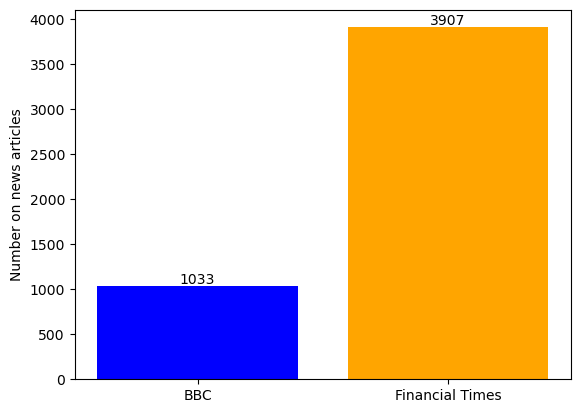

Average sentiment standard deviation for BBC: 0.014469497400346622
Average sentiment standard deviation for Financial Times: 0.03400660273252759


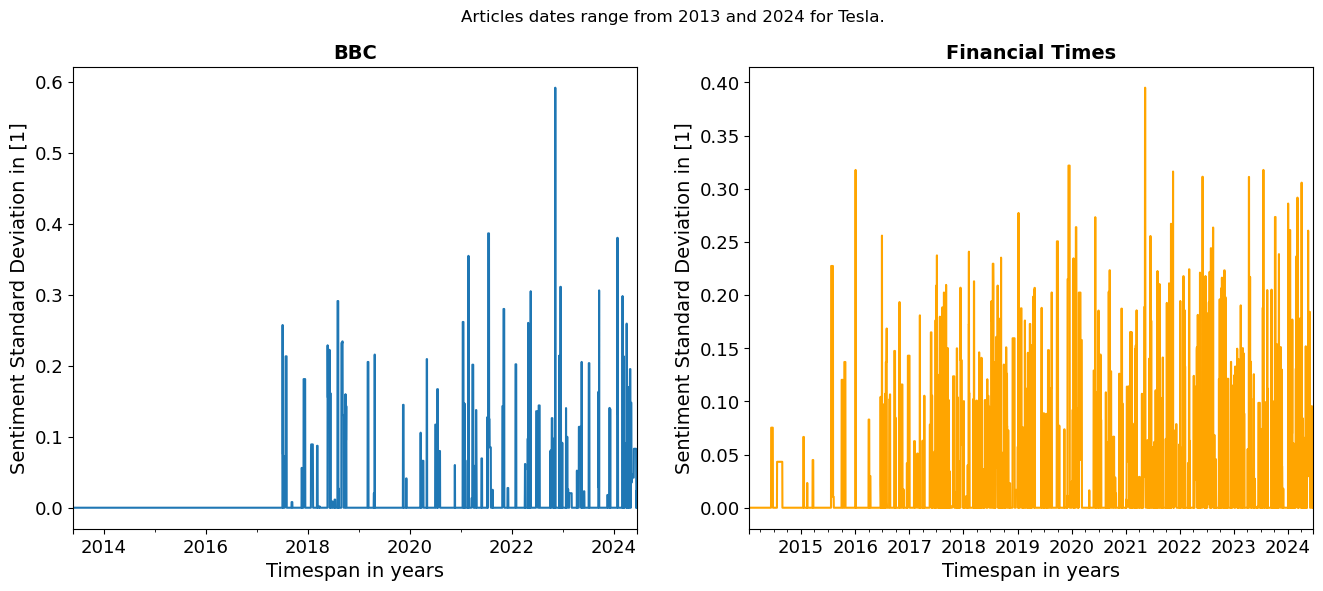

Average amount of news per week for BBC:  3.9523809523809526 0.5646258503401361
Average amount of news per week for FT:  12.272727272727273 1.7532467532467533


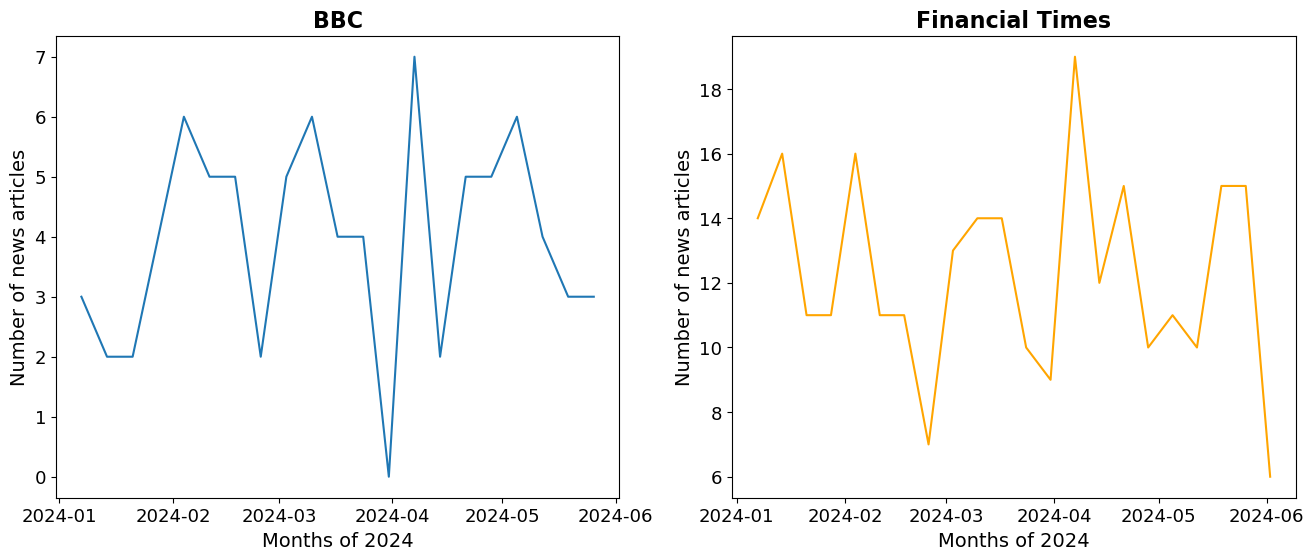

In [5]:
def plot_sources_volume():
    # get the count of data for the source "bbc" and "ft" and display it in bar chart
    prediction_input_repo_bbc = PredictionInputRepository(f"prediction_input/bbc")
    bbc_count = len(prediction_input_repo_bbc.select_all())
    prediction_input_repo_ft = PredictionInputRepository(f"prediction_input/ft")
    ft_count = len(prediction_input_repo_ft.select_all())

    fig, ax = plt.subplots()
    
    # bbc is oldest - based on looking at the input table
    bbc_oldest_article = prediction_input_repo_bbc.select_all().tail(1)["timestamp"].values[0].split("T")[0]
    
    # ft is newest - based on looking at the input table
    ft_newest_article = prediction_input_repo_ft.select_all().head(1)["timestamp"].values[0].split("T")[0]    
    
    print(f"Articles dates range from {bbc_oldest_article} and {ft_newest_article} for Tesla.")
    
    # plt.bar(["BBC", "Financial Times"], [bbc_count, ft_count])
    ax.bar_label(plt.bar(["BBC", "Financial Times"], [bbc_count, ft_count], color=['blue', 'orange']))
    ax.set_ylabel("Number on news articles")
    
    # fig.suptitle(
    #     f"Articles dates range from {bbc_oldest_article} and {ft_newest_article} for Tesla.",
    #     fontsize=12,
    #     verticalalignment='bottom',
    #     y = 0.95
    # )
    
    # ax.set_title(
    #     "Comparison of the number of news articles between BBC and Financial Times",
    #     fontsize=15,
    #     verticalalignment='top',
    #     y = 1.2
    # )

    plt.show()
    
def plot_standard_deviation_sentiment():
    prediction_input_repo_bbc = PredictionInputRepository(f"prediction_input/bbc")
    prediction_input_repo_ft = PredictionInputRepository(f"prediction_input/ft")

    bbc_df, (_, _) = get_processed_dataframe_prediction_input("bbc", statistics=True)
    ft_df, (_, _) = get_processed_dataframe_prediction_input("ft", statistics=True)

    bbc_oldest_article_year = prediction_input_repo_bbc.select_all().tail(1)["timestamp"].values[0].split("-")[0]
    ft_newest_article_year = prediction_input_repo_ft.select_all().head(1)["timestamp"].values[0].split("-")[0]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    bbc_df["sentimentPolarity_std"].reset_index().plot(
        x="timestamp", 
        y="sentimentPolarity_std",
        label=None,
        ax=ax1, 
        title="BBC",
    )

    ft_df["sentimentPolarity_std"].reset_index().plot(
        x="timestamp", 
        y="sentimentPolarity_std",
        label=None,
        ax=ax2, 
        color="orange"
    )

    ax1.get_legend().remove()
    ax2.get_legend().remove()

    ax1.set_title("BBC", x = 0.5, weight="bold", fontsize=14)
    ax2.set_title("Financial Times", x = 0.5, weight="bold", fontsize=14)

    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax2.tick_params(axis='both', which='major', labelsize=13)

    ax1.set_ylabel("Sentiment Standard Deviation in [1]", fontsize=14)
    ax2.set_ylabel("Sentiment Standard Deviation in [1]", fontsize=14)
    ax1.set_xlabel("Timespan in years", fontsize=14)
    ax2.set_xlabel("Timespan in years", fontsize=14)

    fig.suptitle('Comparing sentiment standard deviation between BBC and Financial Times', fontsize=16)
    
    fig.suptitle(
        f"Articles dates range from {bbc_oldest_article_year} and {ft_newest_article_year} for Tesla.",
        fontsize=12,
        horizontalalignment='center',
        verticalalignment='bottom',
        y = 0.95
    )
    
    average_std_bbc = bbc_df["sentimentPolarity_std"].mean()
    average_std_ft = ft_df["sentimentPolarity_std"].mean()
    
    print(f"Average sentiment standard deviation for BBC: {average_std_bbc}")
    print(f"Average sentiment standard deviation for Financial Times: {average_std_ft}")

    # plt.title(
    #     "Comparing sentiment standard deviation between BBC and Financial Times",
    #     fontsize=15,
    #     verticalalignment='top',
    #     y = 1.2,
    #     x = -0.1
    # )
    
    plt.show()
    
    pass
    
def plot_weekly_news_frequency(source):
    bbc_df = PredictionInputRepository(f"prediction_input/bbc").select_all()
    ft_df = PredictionInputRepository(f"prediction_input/ft").select_all()

    bbc_df["timestamp"] = bbc_df["timestamp"].transform(lambda x: x.split("T")[0])
    ft_df["timestamp"] = ft_df["timestamp"].transform(lambda x: x.split("T")[0])

    bbc_df = bbc_df[bbc_df.apply(lambda x: '2024-01-01' <= x['timestamp'] <= '2024-06-01', axis=1)]
    ft_df = ft_df[ft_df.apply(lambda x: '2024-01-01' <= x['timestamp'] <= '2024-06-01', axis=1)]

    # Ensure the timestamp column is in datetime format
    bbc_df['timestamp'] = pd.to_datetime(bbc_df['timestamp'])
    ft_df['timestamp'] = pd.to_datetime(ft_df['timestamp'])

    # Set the timestamp column as the index
    bbc_df.set_index('timestamp', inplace=True)
    ft_df.set_index('timestamp', inplace=True)

    # Resample the data by week and count the number of news articles per week
    news_per_week_bbc = bbc_df.resample('W').size()
    news_per_week_ft = ft_df.resample('W').size()
    
    print("Average amount of news per week for BBC: ", news_per_week_bbc.mean() , news_per_week_bbc.mean()/7)
    print("Average amount of news per week for FT: ",news_per_week_ft.mean(), news_per_week_ft.mean()/7)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    
    ax1.plot(
        news_per_week_bbc,
        label="Weekly News Frequency for BBC",
    )

    ax2.plot(
        news_per_week_ft,
        label="Weekly News Frequency for Financial Times",
        color="orange"
    )

    ax1.set_title("BBC", x = 0.5, weight="bold", fontsize=16)
    ax2.set_title("Financial Times", x = 0.5, weight="bold", fontsize=16)

    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax2.tick_params(axis='both', which='major', labelsize=13)

    ax1.set_ylabel("Number of news articles", fontsize=14)
    ax2.set_ylabel("Number of news articles", fontsize=14)
    ax1.set_xlabel("Months of 2024", fontsize=14)
    ax2.set_xlabel("Months of 2024", fontsize=14)

    plt.show()

plot_sources_volume()
plot_standard_deviation_sentiment()
plot_weekly_news_frequency("ft")

# Transform multivariate time series to supervised learning input

This part relies on this blog post: 
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [53]:
def prepare_multivariate_generator_input_data(input_df, n_input):    
    in_seq_list = []
    
    for i in range(len(input_df.columns)):
        values = input_df.iloc[:, i].values
        values = values.reshape((len(values), 1))
        in_seq_list.append(values)
        
    dataset = hstack(tuple(in_seq_list))
    
    # print(dataset)

    n_features = dataset.shape[1]
    
    generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=8)
    
    return generator, n_features

testing_generator_mv_input_df = prepare_multivariate_generator_input_data(testing_df.tail(10), 3)

# Split the data into training and test data

In [54]:
def get_train_test_validation_data_generator(df, n_input):
    train_test_split_ratio = 0.90
    train_validation_split_ratio = 0.80

    split_index_train = int(len(df) * train_test_split_ratio)
    split_index_validation = int(len(df) * train_validation_split_ratio)

    train_df = df[:split_index_train]
    test_df = df[split_index_train:]
    val_df = train_df[split_index_validation:]

    train_gen, _ = prepare_multivariate_generator_input_data(train_df, n_input)
    test_gen, _ = prepare_multivariate_generator_input_data(test_df, n_input)
    val_gen, _ = prepare_multivariate_generator_input_data(val_df, n_input)
    
    return train_gen, test_gen, val_gen


# Create the two-layer LSTM model

In [65]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

def create_model_generator(n_input, n_features):
    model_seq_gen = Sequential()
    model_seq_gen.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
    # model_seq_gen.add(Dropout(0.3))
    # model_seq_gen.add(LSTM(50, return_sequences=False))
    # model_seq_gen.add(Dropout(0.2))
    model_seq_gen.add(Dense(n_features))
    model_seq_gen.compile(optimizer='adam', loss='mse', metrics=["mse", "mape", RootMeanSquaredError(), "accuracy"])
    return model_seq_gen    


def fit_model_generator(model_seq_gen, gen_dataset, epochs = None, steps_per_epoch = None):
    # fit model
    EPOCHS = 100 if epochs is None else epochs
    STEPS_PER_EPOCH = 1 if steps_per_epoch is None else steps_per_epoch

    fit_res_gen = model_seq_gen.fit(gen_dataset, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=0)

    # model_seq_gen.summary()

    return fit_res_gen

def fit_model_generator_validation(model_seq_gen, train_gen, val_gen, epochs = None, steps_per_epoch = None):
    # fit model
    EPOCHS = 100 if epochs is None else epochs
    STEPS_PER_EPOCH = 1 if steps_per_epoch is None else steps_per_epoch

    fit_res_gen = model_seq_gen.fit(
        train_gen,
        validation_data = val_gen,
        steps_per_epoch=STEPS_PER_EPOCH, 
        epochs=EPOCHS,
        callbacks=[callback],
        verbose=0
    )

    # model_seq_gen.summary()

    return fit_res_gen 


def plot_history(history):
    # plot history
    plt.plot(history['loss'], label=f'Loss during Training')
    plt.plot(history[f'val_loss'], label=f'Loss during Validation')
    plt.xlabel("Epochs")
    plt.ylabel("loss value")
    plt.legend()
    plt.show()
    
def plot_metrics(metrics):

    plt.plot(metrics['mse'], label=f'MSE')
    plt.plot(metrics['val_mse'], label=f'Validation MSE')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.show()

    # plt.plot(metrics['accuracy'], label=f'Prediction Accuracy')
    # plt.xlabel("Epochs")
    # plt.ylabel("Accuracy")
    # plt.legend()
    # plt.show()

def plot_table_stock_and_predicted(stock_df, input_df):
    data_new = []
    
    columns = ('Actual Close Price', 'Predicted Close Price', 'Error')
    rows = []
    
    row_dict = {index:stock_df.loc[index, 'close'] for index in stock_df.index}

    for timestamp in row_dict:
        if timestamp in input_df.index:
            rows.append(timestamp.strftime("%Y-%m-%d"))
            error = stock_df.loc[timestamp]["close"] - input_df.loc[timestamp]["close"]
            
            data_new.append([round(stock_df.loc[timestamp]["close"],4), round(input_df.loc[timestamp]["close"],4), round(error,4)])
    
    fig, ax = plt.subplots()

    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=data_new, colLabels=columns, rowLabels=rows, loc='top')
    plt.show()


In [76]:
def get_prediction_generator(model, input_df, n_input, n_features):
    train_input = input_df.tail(n_input).iloc[-n_input:].values
    x_input = array(train_input).reshape((1, n_input, n_features))
    prediction = model.predict(x_input, verbose=0)
    return prediction

def plot_prediction_result(predicted_close, train_y, test_y, min_close, max_close):
    test_Y_test = np.append(train_y, test_y)
    predicted_close_test = np.append(train_y, predicted_close)
    
    plt.figure(figsize=(16,10))
    plt.plot(test_Y_test, label='Test - Close')
    plt.plot(predicted_close_test, label='Predicted - Close')
    plt.plot(train_y, label='Train')

    plt.xlabel("days")
    plt.ylabel("price")
    plt.legend(bbox_to_anchor =(1, 1), fontsize=15)
    plt.show()

    rmse = sqrt(mean_squared_error(predicted_close, test_y))
    print('Test RMSE: %.3f ' % rmse)
    
def run_prediction_generator(source, exclude_col=None):
    if exclude_col is None:
        exclude_col = []
        
    keras_backend.clear_session()

    warnings.filterwarnings('ignore')
    warnings.simplefilter('ignore')
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    future_days_predictions = 7
    
    n_input = future_days_predictions # 7

    input_df, (min_close, max_close) = get_processed_dataframe_prediction_input(source, exclude_col, statistics=False)
    
    max_date = input_df.index.max()

    print(input_df.tail(10))
    
    steps_per_epoch = 7
    # 
    # print("epochs: ", epochs)
    # print("steps_per_epoch: ", steps_per_epoch)
    # print("epochs * steps_per_epoch: ", epochs * steps_per_epoch)
    # print("len(input_df): ", len(input_df))
    
    history = None
          
    predictions_future = []

    for future_day in range(0, future_days_predictions):
        keras_backend.clear_session()

        print(f"Calculating {future_day+1} days into the future ...")

        gen_dataset, _ = prepare_multivariate_generator_input_data(input_df, n_input)

        train_gen, test_gen, val_gen = get_train_test_validation_data_generator(input_df, n_input)

        n_features = len(input_df.columns.values)        

        model_gen = create_model_generator(n_input, n_features)

        if history is None:
            # Only used for validation
            fit_res_gen_validation = fit_model_generator_validation(
                model_gen,
                gen_dataset,
                val_gen=val_gen,
                steps_per_epoch = steps_per_epoch)
            
            history = fit_res_gen_validation.history if history is None else history

        fit_model_generator(
            model_gen,
            gen_dataset,
            steps_per_epoch = steps_per_epoch)

        predictions = get_prediction_generator(model_gen, input_df, n_input, n_features)

        # print(predictions)

        new_row = pd.DataFrame({
            key: value for key, value in zip(input_df.columns, predictions[0])
        }, columns=input_df.columns, index=[max_date + pd.Timedelta(days=future_day + 1)])
        input_df = pd.concat([input_df, new_row])

        predictions_future.append({
            "timestamp" : max_date + pd.Timedelta(days=future_day + 1),
            "close": np.interp(predictions[0][-1], (0, 1), (min_close, max_close))
        })

    print(f"Predicted future values for the next {future_days_predictions} days: ")
    print(input_df.tail(future_days_predictions))

    # plot_history(history)
    plot_metrics(history)
        
    print("MSE: ", np.array(history["mse"]).mean())
    print("Accuracy: ", round(np.array(history["accuracy"]).mean() * 100, 2) , "%")

    stock_df = yf.get_data(
        STOCK,
        start_date="2024-03-15",
        end_date=(max_date + pd.Timedelta(days=future_days_predictions+1)).strftime("%Y-%m-%d"),
        interval='1d')

    stock_df = stock_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
    stock_df.index.names = ['timestamp']
    stock_df.reset_index()
    #stock_df["close"] = np.interp(stock_df["close"].ffill().bfill(), (min_close, max_close), (0, 1))
    input_df["close"] = np.interp(input_df["close"], (0, 1), (min_close, max_close))

    plt.figure(figsize=(16,10))
    plt.plot(stock_df.tail(20), label='Actual - Close')
    plt.plot(input_df.tail(20)["close"], label="Preprocessed Prediction Input")
    plt.plot(input_df.tail(future_days_predictions)["close"], label='Predicted - Close')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=16)
    plt.xlabel("days", fontsize=20)
    plt.ylabel("price in dollar", fontsize=20)
    plt.legend(bbox_to_anchor =(1, 1), fontsize=15)
    plt.show()
    
    plot_table_stock_and_predicted(stock_df, input_df.tail(future_days_predictions))

    # print(stock_df.tail(future_days_predictions))

In [77]:
# run_prediction_generator("ft")
# run_prediction_generator("ft", exclude_col = ["sentimentPolarity"])
# run_prediction_generator("ft", exclude_col = ["relevance"])
# run_prediction_generator("ft", exclude_col = ["sentimentPolarity", "relevance"])

# FT Stock Prediction

            relevance  sentimentPolarity    close
timestamp                                        
2024-06-09    0.92042            0.51813  0.41934
2024-06-10    0.95407            0.43868  0.41013
2024-06-11    0.92318            0.50883  0.40231
2024-06-12    0.95280            0.47494  0.41887
2024-06-13    0.95280            0.47494  0.43181
2024-06-14    0.97479            0.50920  0.42067
2024-06-15    0.97479            0.50920  0.42067
2024-06-16    0.97479            0.50920  0.42067
2024-06-17    0.94111            0.48388  0.44422
2024-06-18    0.94550            0.28062  0.44422
Calculating 1 days into the future ...
Calculating 2 days into the future ...
Calculating 3 days into the future ...
Calculating 4 days into the future ...
Calculating 5 days into the future ...
Calculating 6 days into the future ...
Calculating 7 days into the future ...
Predicted future values for the next 7 days: 
            relevance  sentimentPolarity     close
2024-06-19   0.913040         

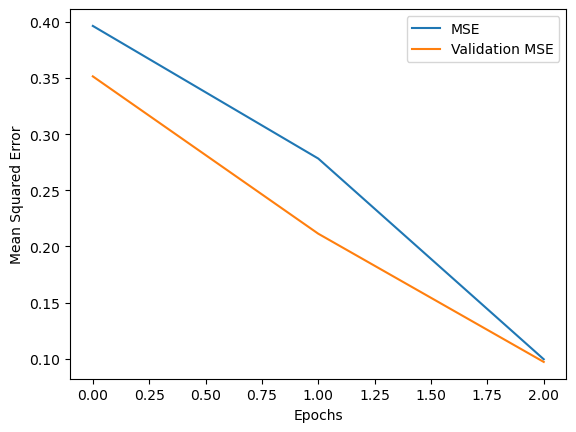

MSE:  0.2581055189172427
Accuracy:  85.71 %


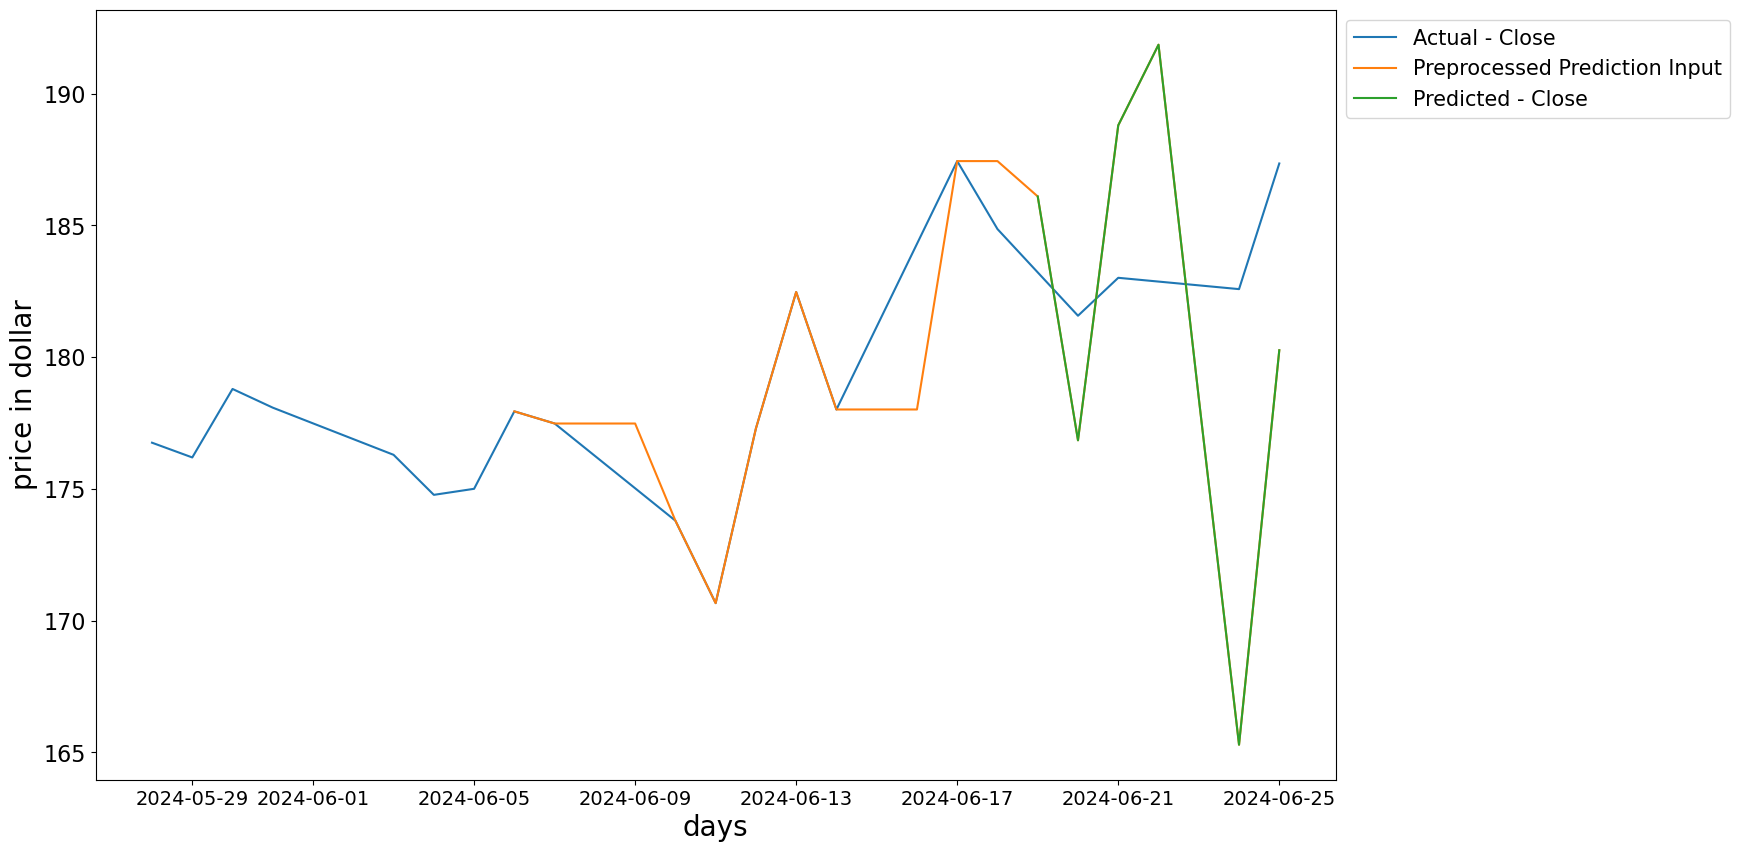

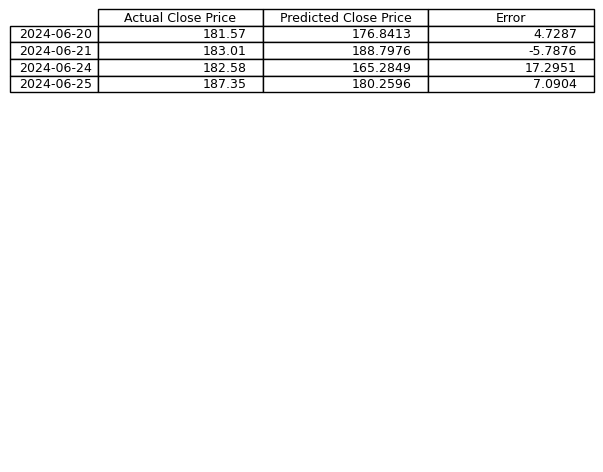

In [78]:
run_prediction_generator("ft")

            sentimentPolarity    close
timestamp                             
2024-06-09            0.51813  0.41934
2024-06-10            0.43868  0.41013
2024-06-11            0.50883  0.40231
2024-06-12            0.47494  0.41887
2024-06-13            0.47494  0.43181
2024-06-14            0.50920  0.42067
2024-06-15            0.50920  0.42067
2024-06-16            0.50920  0.42067
2024-06-17            0.48388  0.44422
2024-06-18            0.28062  0.44422
Calculating 1 days into the future ...
Calculating 2 days into the future ...
Calculating 3 days into the future ...
Calculating 4 days into the future ...
Calculating 5 days into the future ...
Calculating 6 days into the future ...
Calculating 7 days into the future ...
Predicted future values for the next 7 days: 
            sentimentPolarity     close
2024-06-19           0.468716  0.439631
2024-06-20           0.486564  0.445269
2024-06-21           0.462041  0.423569
2024-06-22           0.456459  0.391449
2024-06-23   

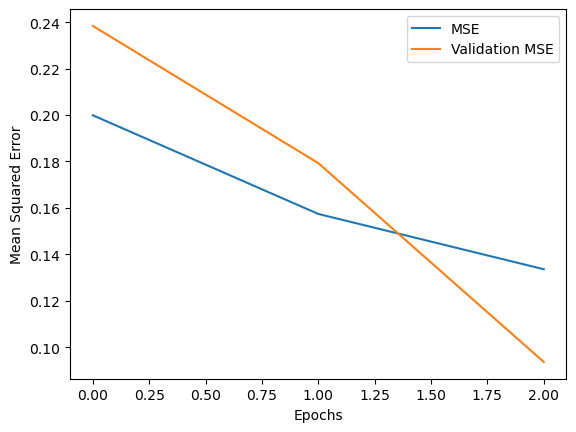

MSE:  0.1636281112829844
Accuracy:  74.4 %


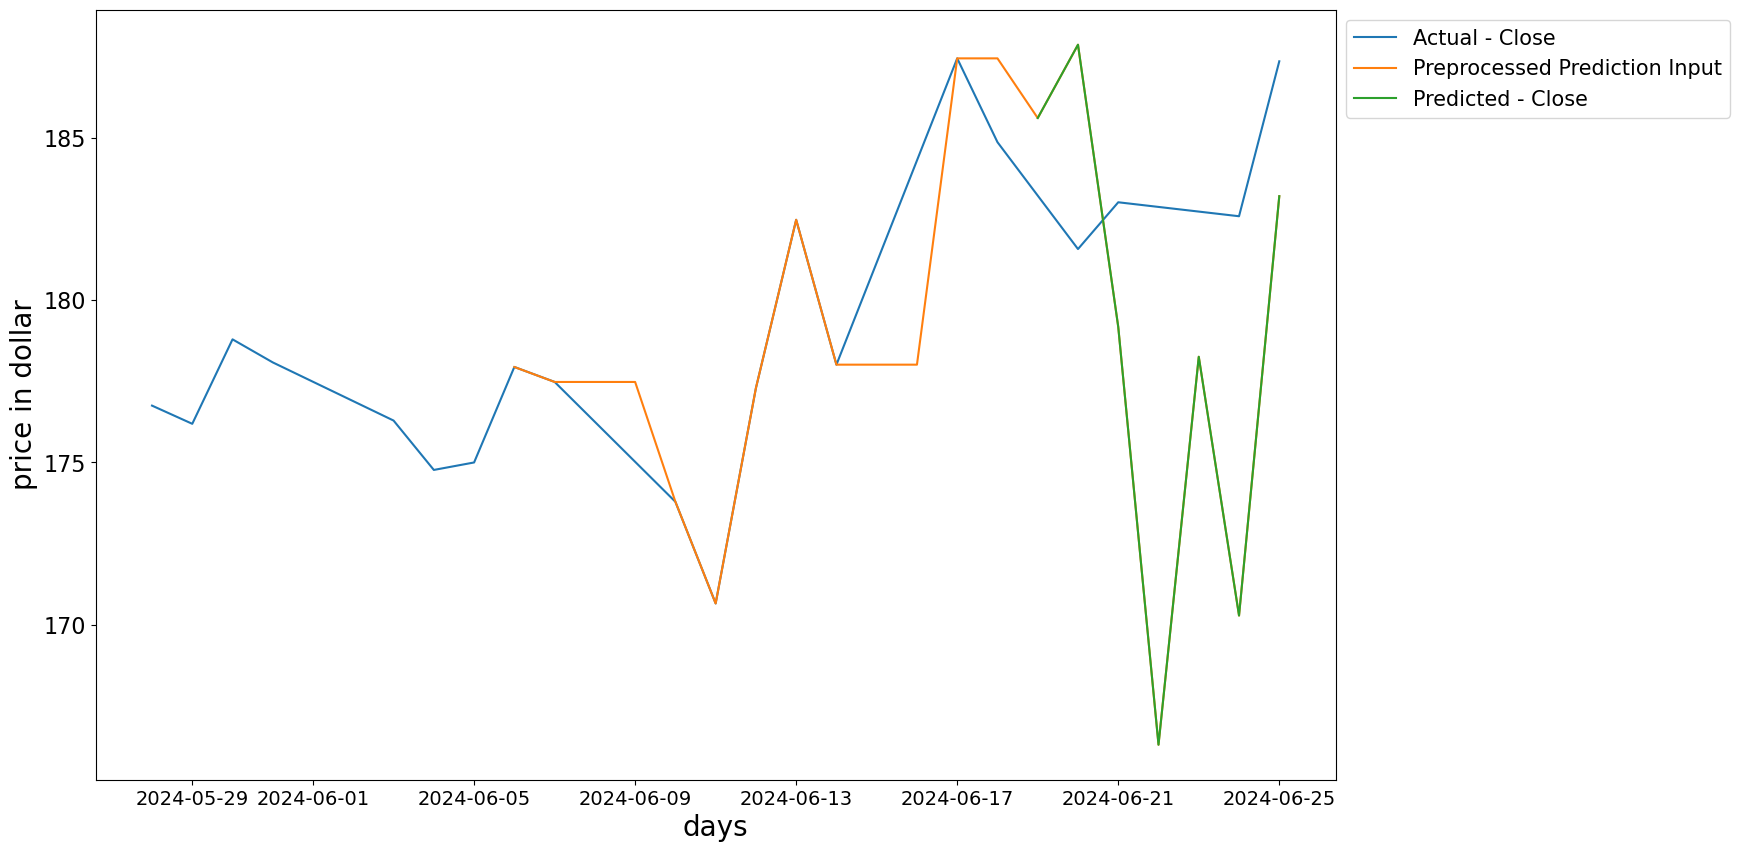

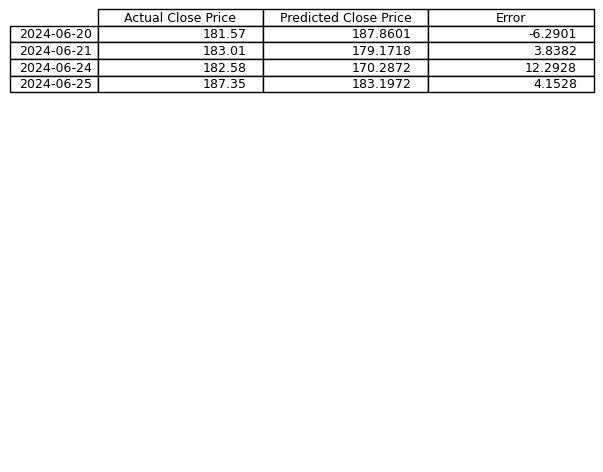

In [74]:
run_prediction_generator("ft", exclude_col = ["relevance"])

              close
timestamp          
2024-06-09  0.41934
2024-06-10  0.41013
2024-06-11  0.40231
2024-06-12  0.41887
2024-06-13  0.43181
2024-06-14  0.42067
2024-06-15  0.42067
2024-06-16  0.42067
2024-06-17  0.44422
2024-06-18  0.44422
Calculating 1 days into the future ...
Calculating 2 days into the future ...
Calculating 3 days into the future ...
Calculating 4 days into the future ...
Calculating 5 days into the future ...
Calculating 6 days into the future ...
Calculating 7 days into the future ...
Predicted future values for the next 7 days: 
               close
2024-06-19  0.457794
2024-06-20  0.436778
2024-06-21  0.439972
2024-06-22  0.441969
2024-06-23  0.452067
2024-06-24  0.466697
2024-06-25  0.425845


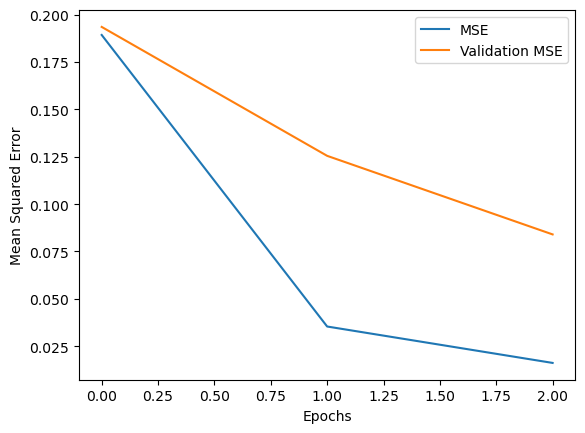

MSE:  0.08027115588386853
Accuracy:  0.0 %


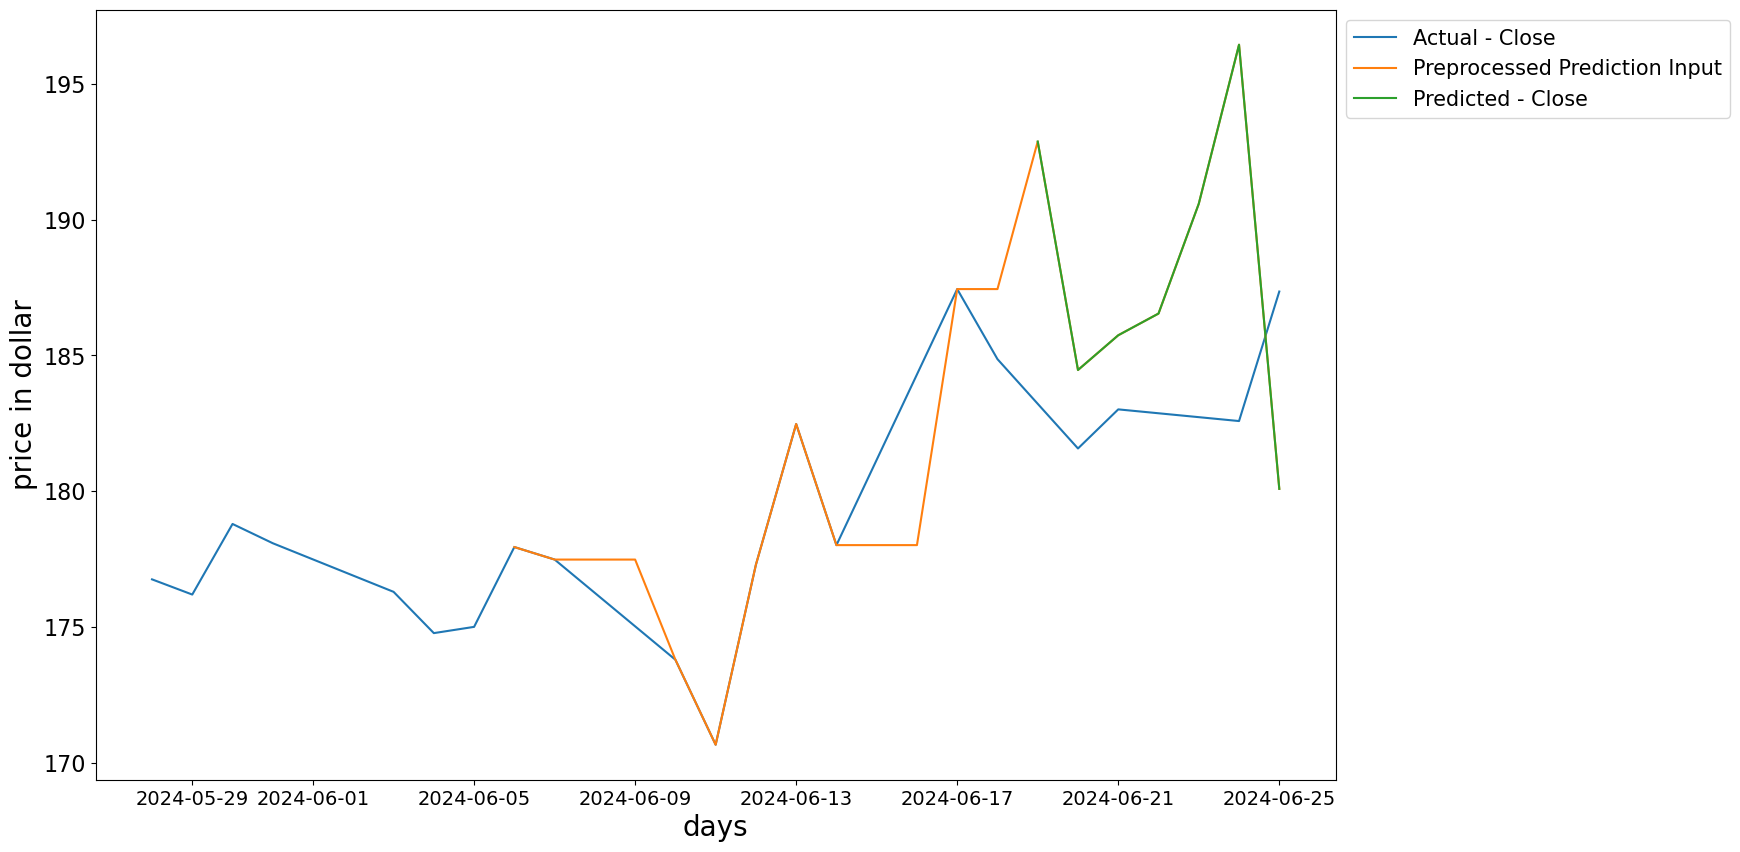

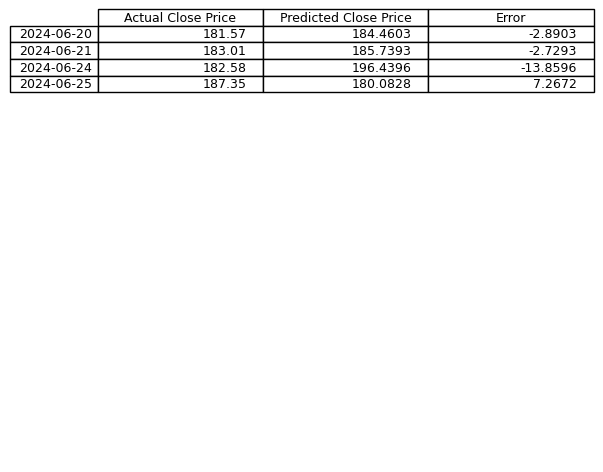

In [75]:
run_prediction_generator("ft", exclude_col = ["relevance", "sentimentPolarity"])

# BBC Stock Prediction

            relevance  sentimentPolarity    close
timestamp                                        
2024-06-04    0.95353            0.38176  0.41753
2024-06-05    0.95353            0.38176  0.41810
2024-06-06    0.95353            0.38176  0.42538
2024-06-07    0.95353            0.38176  0.42424
2024-06-08    0.95353            0.38176  0.42424
2024-06-09    0.95353            0.38176  0.42424
2024-06-10    0.95546            0.50252  0.41510
2024-06-11    0.92376            0.56320  0.40735
2024-06-12    0.95300            0.36698  0.42377
2024-06-13    0.92994            0.61906  0.42377
Calculating 1 days into the future ...
Calculating 2 days into the future ...
Calculating 3 days into the future ...
Calculating 4 days into the future ...
Calculating 5 days into the future ...
Calculating 6 days into the future ...
Calculating 7 days into the future ...
Predicted future values for the next 7 days: 
            relevance  sentimentPolarity     close
2024-06-14   0.871663         

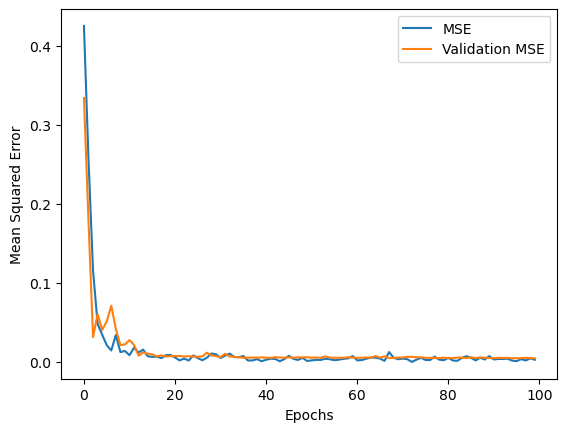

MSE:  0.013974587037228047
Accuracy:  96.84 %


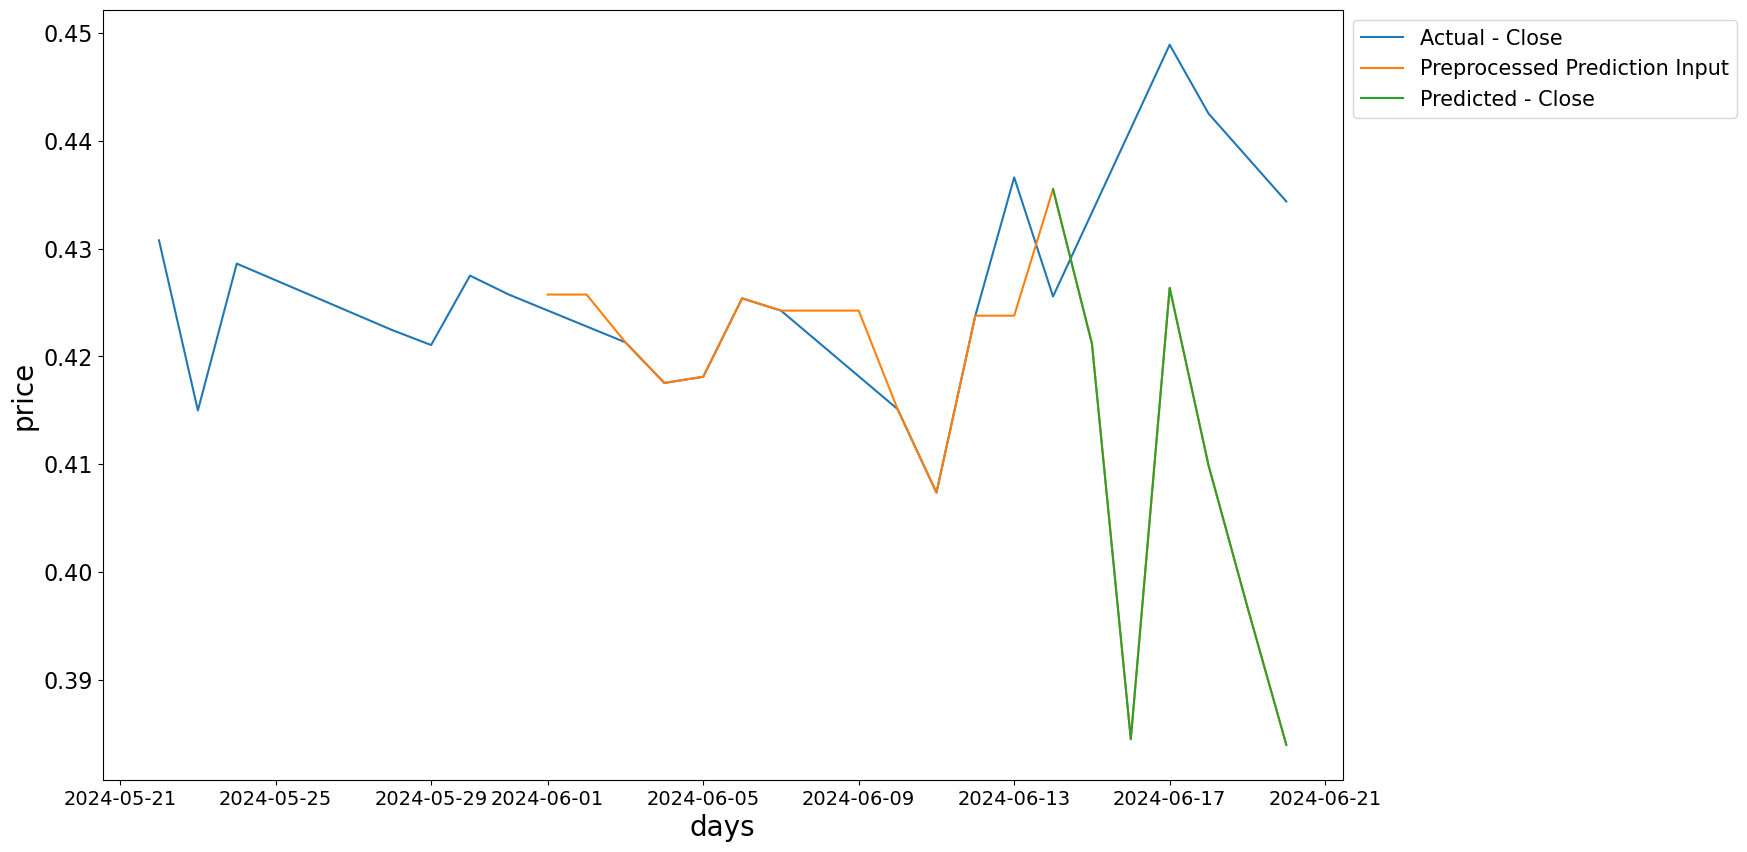

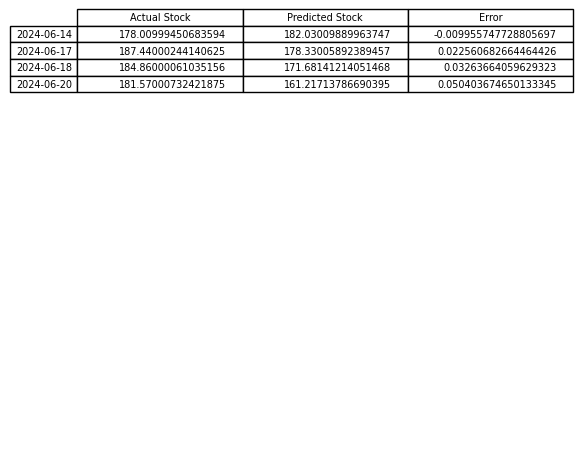

In [32]:
run_prediction_generator("bbc")

            sentimentPolarity    close
timestamp                             
2024-06-04            0.38176  0.41753
2024-06-05            0.38176  0.41810
2024-06-06            0.38176  0.42538
2024-06-07            0.38176  0.42424
2024-06-08            0.38176  0.42424
2024-06-09            0.38176  0.42424
2024-06-10            0.50252  0.41510
2024-06-11            0.56320  0.40735
2024-06-12            0.36698  0.42377
2024-06-13            0.61906  0.42377
Calculating 1 days into the future ...
Calculating 2 days into the future ...
Calculating 3 days into the future ...
Calculating 4 days into the future ...
Calculating 5 days into the future ...
Calculating 6 days into the future ...
Calculating 7 days into the future ...
Predicted future values for the next 7 days: 
            sentimentPolarity     close
2024-06-14           0.546033  0.426293
2024-06-15           0.511542  0.437948
2024-06-16           0.552358  0.431825
2024-06-17           0.511206  0.392171
2024-06-18   

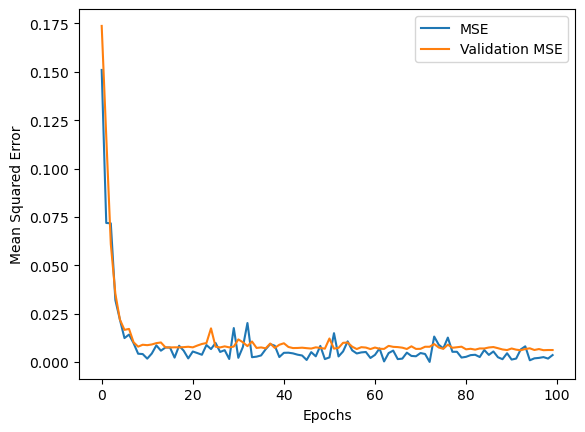

MSE:  0.008430645914631895
Accuracy:  91.2 %


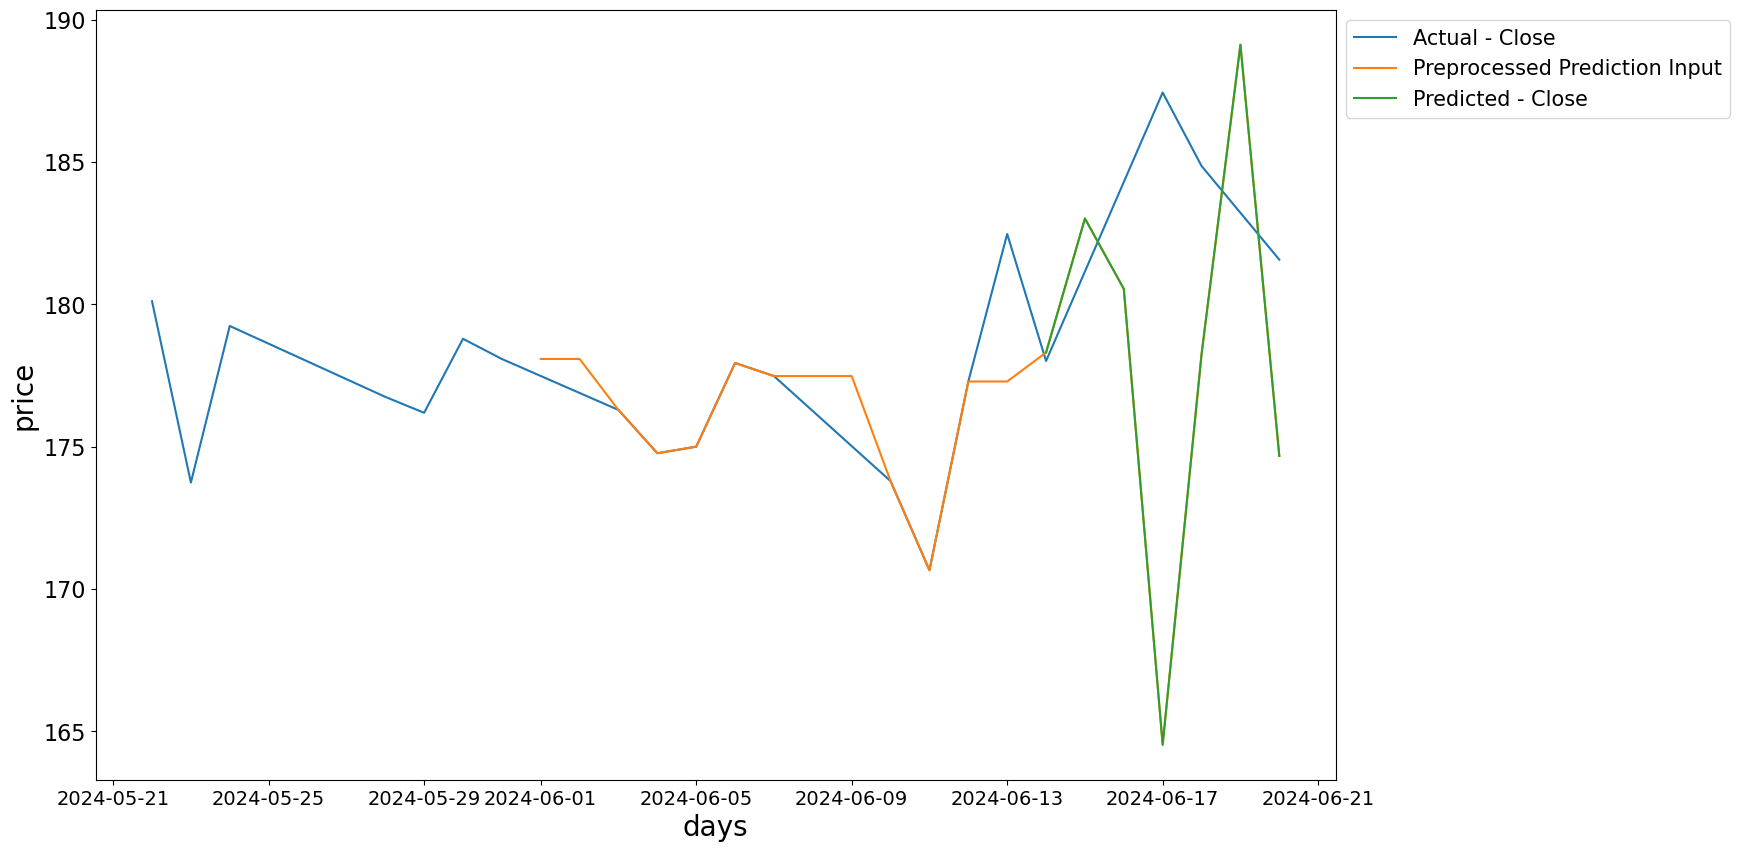

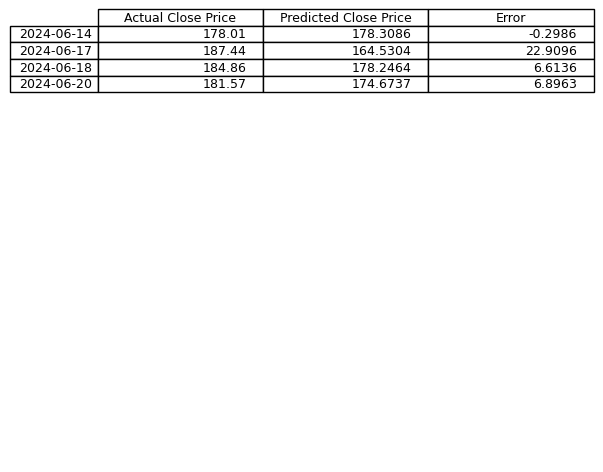

In [51]:
run_prediction_generator("bbc", exclude_col = ["relevance"])

              close
timestamp          
2024-06-04  0.41753
2024-06-05  0.41810
2024-06-06  0.42538
2024-06-07  0.42424
2024-06-08  0.42424
2024-06-09  0.42424
2024-06-10  0.41510
2024-06-11  0.40735
2024-06-12  0.42377
2024-06-13  0.42377
Calculating 1 days into the future ...
Calculating 2 days into the future ...
Calculating 3 days into the future ...
Calculating 4 days into the future ...
Calculating 5 days into the future ...
Calculating 6 days into the future ...
Calculating 7 days into the future ...
Predicted future values for the next 7 days: 
               close
2024-06-14  0.427887
2024-06-15  0.419145
2024-06-16  0.450710
2024-06-17  0.410312
2024-06-18  0.395580
2024-06-19  0.438621
2024-06-20  0.438440


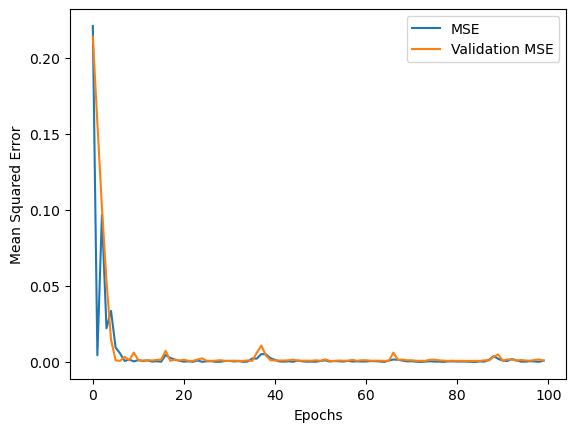

MSE:  0.004635676537091058
Accuracy:  0.04 %


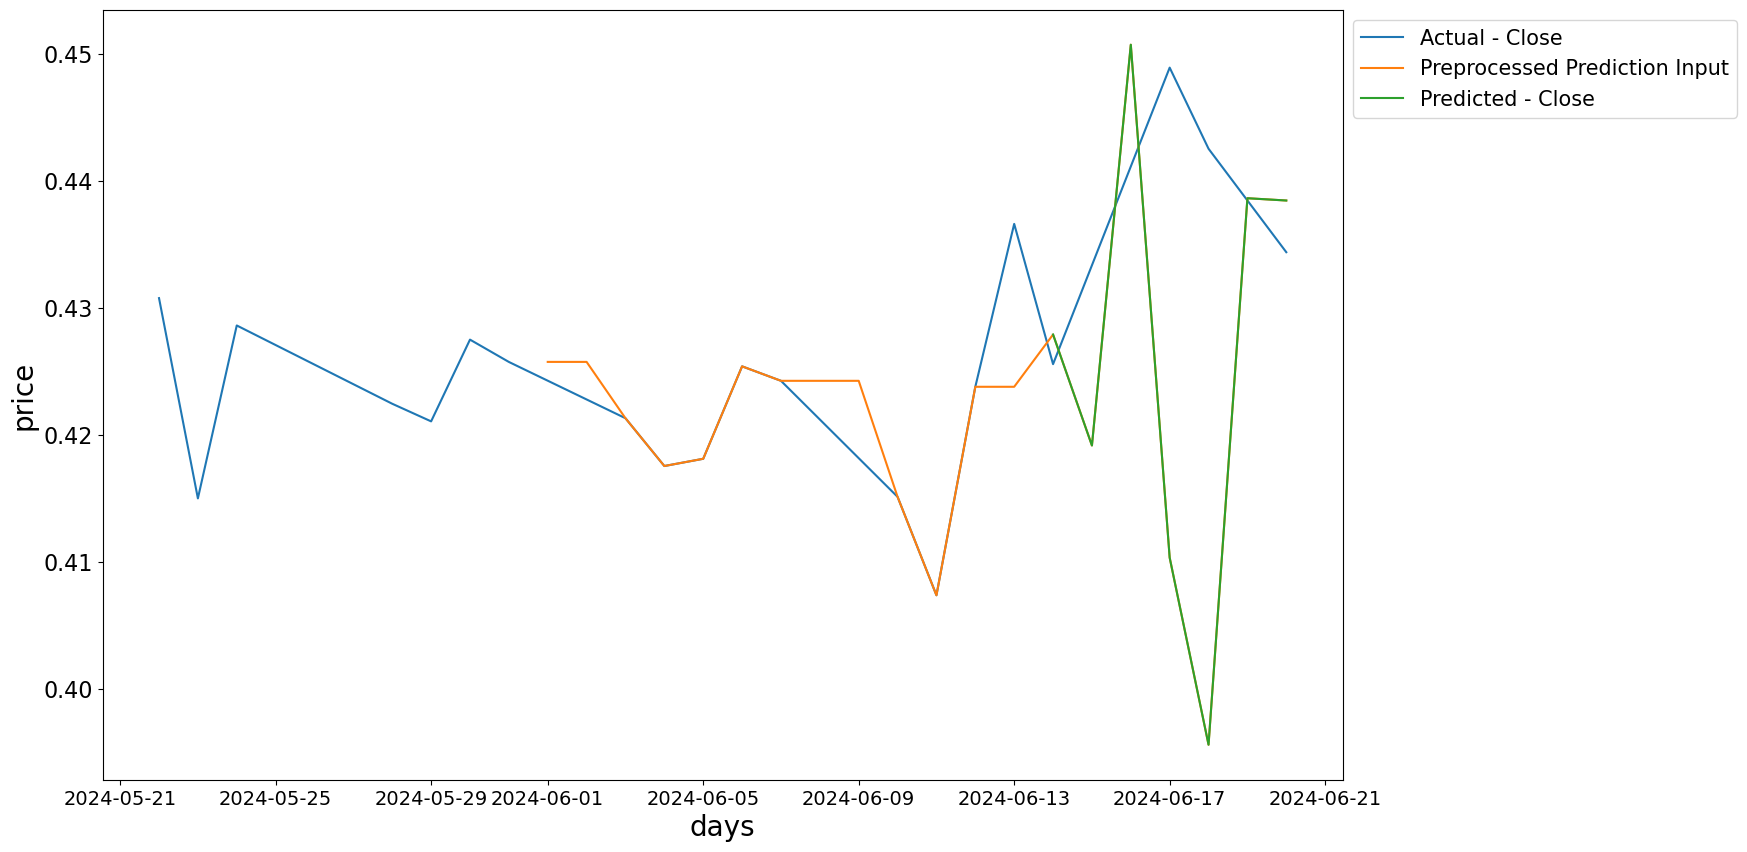

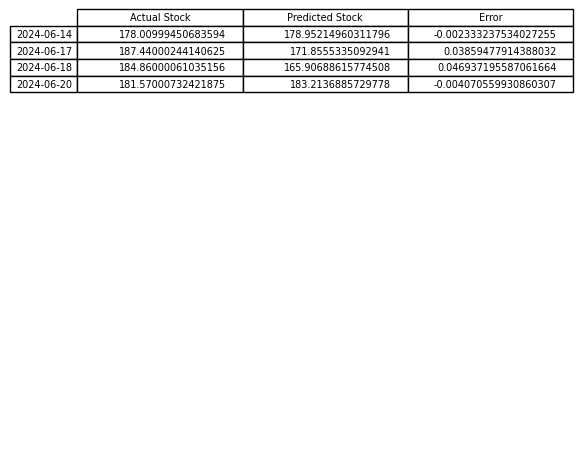

In [34]:
run_prediction_generator("bbc", exclude_col = ["relevance", "sentimentPolarity"])